In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
forecasting = 20

In [4]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [5]:
df = df['Resistance']
df

0      0.259
1      0.260
2      0.259
3      0.259
4      0.259
       ...  
254    0.301
255    0.301
256    0.302
257    0.300
258    0.296
Name: Resistance, Length: 259, dtype: float64

<AxesSubplot:>

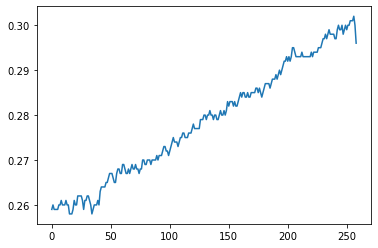

In [6]:
df.plot()

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [8]:
train = df_scaled

In [9]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [10]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [11]:
x_train.shape

(191, 20, 1)

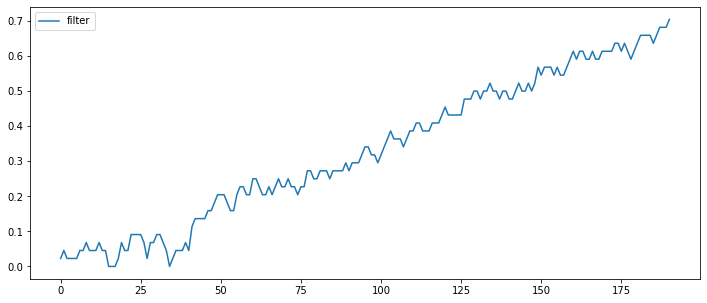

In [12]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

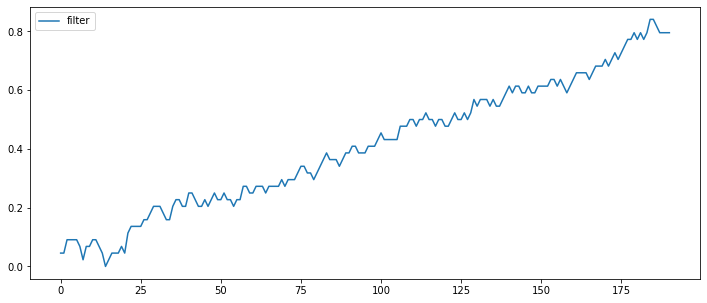

In [13]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [14]:
OUT_STEPS = 20

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [16]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=800, 
                    batch_size=16)

Epoch 1/800
12/12 [==============================] - 1s 5ms/step - loss: 0.1745 - mean_absolute_error: 0.3602
Epoch 2/800
12/12 [==============================] - 0s 4ms/step - loss: 0.1479 - mean_absolute_error: 0.3262
Epoch 3/800
12/12 [==============================] - 0s 5ms/step - loss: 0.1199 - mean_absolute_error: 0.2885
Epoch 4/800
12/12 [==============================] - 0s 4ms/step - loss: 0.0908 - mean_absolute_error: 0.2464
Epoch 5/800
12/12 [==============================] - 0s 4ms/step - loss: 0.0522 - mean_absolute_error: 0.1789
Epoch 6/800
12/12 [==============================] - 0s 5ms/step - loss: 0.0279 - mean_absolute_error: 0.1322
Epoch 7/800
12/12 [==============================] - 0s 4ms/step - loss: 0.0158 - mean_absolute_error: 0.1021
Epoch 8/800
12/12 [==============================] - 0s 4ms/step - loss: 0.0092 - mean_absolute_error: 0.0769
Epoch 9/800
12/12 [==============================] - 0s 4ms/step - loss: 0.0045 - mean_absolute_error: 0.0501
Epoch 10/8

12/12 [==============================] - 0s 4ms/step - loss: 6.2507e-04 - mean_absolute_error: 0.0192
Epoch 73/800
12/12 [==============================] - 0s 5ms/step - loss: 5.6626e-04 - mean_absolute_error: 0.0186
Epoch 74/800
12/12 [==============================] - 0s 4ms/step - loss: 5.3970e-04 - mean_absolute_error: 0.0181
Epoch 75/800
12/12 [==============================] - 0s 4ms/step - loss: 5.3870e-04 - mean_absolute_error: 0.0180
Epoch 76/800
12/12 [==============================] - 0s 4ms/step - loss: 5.0968e-04 - mean_absolute_error: 0.0178
Epoch 77/800
12/12 [==============================] - 0s 4ms/step - loss: 5.3785e-04 - mean_absolute_error: 0.0183
Epoch 78/800
12/12 [==============================] - 0s 4ms/step - loss: 5.2836e-04 - mean_absolute_error: 0.0180
Epoch 79/800
12/12 [==============================] - 0s 4ms/step - loss: 5.1121e-04 - mean_absolute_error: 0.0178
Epoch 80/800
12/12 [==============================] - 0s 4ms/step - loss: 5.0416e-04 - mean_a

Epoch 143/800
12/12 [==============================] - 0s 5ms/step - loss: 5.4323e-04 - mean_absolute_error: 0.0183
Epoch 144/800
12/12 [==============================] - 0s 5ms/step - loss: 4.8314e-04 - mean_absolute_error: 0.0174
Epoch 145/800
12/12 [==============================] - 0s 5ms/step - loss: 5.3995e-04 - mean_absolute_error: 0.0184
Epoch 146/800
12/12 [==============================] - 0s 5ms/step - loss: 5.2451e-04 - mean_absolute_error: 0.0181
Epoch 147/800
12/12 [==============================] - 0s 4ms/step - loss: 4.8184e-04 - mean_absolute_error: 0.0174
Epoch 148/800
12/12 [==============================] - 0s 5ms/step - loss: 4.9777e-04 - mean_absolute_error: 0.0177
Epoch 149/800
12/12 [==============================] - 0s 5ms/step - loss: 5.3503e-04 - mean_absolute_error: 0.0181
Epoch 150/800
12/12 [==============================] - 0s 5ms/step - loss: 5.0944e-04 - mean_absolute_error: 0.0177
Epoch 151/800
12/12 [==============================] - 0s 5ms/step - los

12/12 [==============================] - 0s 5ms/step - loss: 5.0353e-04 - mean_absolute_error: 0.0178
Epoch 214/800
12/12 [==============================] - 0s 5ms/step - loss: 4.6241e-04 - mean_absolute_error: 0.0171
Epoch 215/800
12/12 [==============================] - 0s 4ms/step - loss: 4.5097e-04 - mean_absolute_error: 0.0169
Epoch 216/800
12/12 [==============================] - 0s 4ms/step - loss: 4.5025e-04 - mean_absolute_error: 0.0169
Epoch 217/800
12/12 [==============================] - 0s 4ms/step - loss: 5.0094e-04 - mean_absolute_error: 0.0177
Epoch 218/800
12/12 [==============================] - 0s 5ms/step - loss: 4.7179e-04 - mean_absolute_error: 0.0172
Epoch 219/800
12/12 [==============================] - 0s 4ms/step - loss: 4.4672e-04 - mean_absolute_error: 0.0168
Epoch 220/800
12/12 [==============================] - 0s 4ms/step - loss: 4.7445e-04 - mean_absolute_error: 0.0172
Epoch 221/800
12/12 [==============================] - 0s 5ms/step - loss: 4.4647e-04 

12/12 [==============================] - 0s 5ms/step - loss: 4.2359e-04 - mean_absolute_error: 0.0164
Epoch 284/800
12/12 [==============================] - 0s 4ms/step - loss: 4.4192e-04 - mean_absolute_error: 0.0169
Epoch 285/800
12/12 [==============================] - 0s 5ms/step - loss: 4.5431e-04 - mean_absolute_error: 0.0171
Epoch 286/800
12/12 [==============================] - 0s 4ms/step - loss: 4.1944e-04 - mean_absolute_error: 0.0163
Epoch 287/800
12/12 [==============================] - 0s 5ms/step - loss: 4.2132e-04 - mean_absolute_error: 0.0164
Epoch 288/800
12/12 [==============================] - 0s 5ms/step - loss: 4.1699e-04 - mean_absolute_error: 0.0163
Epoch 289/800
12/12 [==============================] - 0s 4ms/step - loss: 4.1741e-04 - mean_absolute_error: 0.0163
Epoch 290/800
12/12 [==============================] - 0s 4ms/step - loss: 3.9825e-04 - mean_absolute_error: 0.0160
Epoch 291/800
12/12 [==============================] - 0s 4ms/step - loss: 4.2180e-04 

12/12 [==============================] - 0s 4ms/step - loss: 3.9403e-04 - mean_absolute_error: 0.0159
Epoch 354/800
12/12 [==============================] - 0s 5ms/step - loss: 3.9041e-04 - mean_absolute_error: 0.0159
Epoch 355/800
12/12 [==============================] - 0s 4ms/step - loss: 3.7611e-04 - mean_absolute_error: 0.0156
Epoch 356/800
12/12 [==============================] - 0s 4ms/step - loss: 3.5629e-04 - mean_absolute_error: 0.0151
Epoch 357/800
12/12 [==============================] - 0s 4ms/step - loss: 3.9752e-04 - mean_absolute_error: 0.0160
Epoch 358/800
12/12 [==============================] - 0s 4ms/step - loss: 3.6923e-04 - mean_absolute_error: 0.0154
Epoch 359/800
12/12 [==============================] - 0s 4ms/step - loss: 3.9304e-04 - mean_absolute_error: 0.0158
Epoch 360/800
12/12 [==============================] - 0s 4ms/step - loss: 3.7574e-04 - mean_absolute_error: 0.0155
Epoch 361/800
12/12 [==============================] - 0s 4ms/step - loss: 3.7300e-04 

12/12 [==============================] - 0s 5ms/step - loss: 3.5778e-04 - mean_absolute_error: 0.0151
Epoch 424/800
12/12 [==============================] - 0s 4ms/step - loss: 3.5867e-04 - mean_absolute_error: 0.0152
Epoch 425/800
12/12 [==============================] - 0s 4ms/step - loss: 3.6504e-04 - mean_absolute_error: 0.0153
Epoch 426/800
12/12 [==============================] - 0s 5ms/step - loss: 3.7975e-04 - mean_absolute_error: 0.0157
Epoch 427/800
12/12 [==============================] - 0s 5ms/step - loss: 3.7221e-04 - mean_absolute_error: 0.0155
Epoch 428/800
12/12 [==============================] - 0s 5ms/step - loss: 3.6370e-04 - mean_absolute_error: 0.0153
Epoch 429/800
12/12 [==============================] - 0s 4ms/step - loss: 3.6173e-04 - mean_absolute_error: 0.0153
Epoch 430/800
12/12 [==============================] - 0s 5ms/step - loss: 3.4682e-04 - mean_absolute_error: 0.0149
Epoch 431/800
12/12 [==============================] - 0s 4ms/step - loss: 3.7258e-04 

12/12 [==============================] - 0s 5ms/step - loss: 3.4531e-04 - mean_absolute_error: 0.0149
Epoch 494/800
12/12 [==============================] - 0s 5ms/step - loss: 3.3880e-04 - mean_absolute_error: 0.0146
Epoch 495/800
12/12 [==============================] - 0s 5ms/step - loss: 3.4571e-04 - mean_absolute_error: 0.0148
Epoch 496/800
12/12 [==============================] - 0s 5ms/step - loss: 3.4191e-04 - mean_absolute_error: 0.0147
Epoch 497/800
12/12 [==============================] - 0s 5ms/step - loss: 3.4744e-04 - mean_absolute_error: 0.0148
Epoch 498/800
12/12 [==============================] - 0s 5ms/step - loss: 3.3764e-04 - mean_absolute_error: 0.0147
Epoch 499/800
12/12 [==============================] - 0s 4ms/step - loss: 3.3568e-04 - mean_absolute_error: 0.0147
Epoch 500/800
12/12 [==============================] - 0s 4ms/step - loss: 3.4596e-04 - mean_absolute_error: 0.0149
Epoch 501/800
12/12 [==============================] - 0s 4ms/step - loss: 3.4856e-04 

12/12 [==============================] - 0s 4ms/step - loss: 3.1370e-04 - mean_absolute_error: 0.0141
Epoch 564/800
12/12 [==============================] - 0s 5ms/step - loss: 3.1549e-04 - mean_absolute_error: 0.0142
Epoch 565/800
12/12 [==============================] - 0s 5ms/step - loss: 3.1784e-04 - mean_absolute_error: 0.0143
Epoch 566/800
12/12 [==============================] - 0s 5ms/step - loss: 3.1935e-04 - mean_absolute_error: 0.0143
Epoch 567/800
12/12 [==============================] - 0s 5ms/step - loss: 3.3673e-04 - mean_absolute_error: 0.0146
Epoch 568/800
12/12 [==============================] - 0s 4ms/step - loss: 3.1935e-04 - mean_absolute_error: 0.0142
Epoch 569/800
12/12 [==============================] - 0s 4ms/step - loss: 3.2900e-04 - mean_absolute_error: 0.0145
Epoch 570/800
12/12 [==============================] - 0s 4ms/step - loss: 3.2606e-04 - mean_absolute_error: 0.0145
Epoch 571/800
12/12 [==============================] - 0s 5ms/step - loss: 3.2001e-04 

12/12 [==============================] - 0s 5ms/step - loss: 3.1192e-04 - mean_absolute_error: 0.0141
Epoch 633/800
12/12 [==============================] - 0s 5ms/step - loss: 3.2533e-04 - mean_absolute_error: 0.0145
Epoch 634/800
12/12 [==============================] - 0s 5ms/step - loss: 3.1160e-04 - mean_absolute_error: 0.0140
Epoch 635/800
12/12 [==============================] - 0s 6ms/step - loss: 3.0257e-04 - mean_absolute_error: 0.0139
Epoch 636/800
12/12 [==============================] - 0s 5ms/step - loss: 3.0672e-04 - mean_absolute_error: 0.0139
Epoch 637/800
12/12 [==============================] - 0s 5ms/step - loss: 3.1280e-04 - mean_absolute_error: 0.0141
Epoch 638/800
12/12 [==============================] - 0s 5ms/step - loss: 3.1263e-04 - mean_absolute_error: 0.0141
Epoch 639/800
12/12 [==============================] - 0s 5ms/step - loss: 3.1461e-04 - mean_absolute_error: 0.0143
Epoch 640/800
12/12 [==============================] - 0s 5ms/step - loss: 3.1676e-04 

12/12 [==============================] - 0s 5ms/step - loss: 2.9602e-04 - mean_absolute_error: 0.0137
Epoch 703/800
12/12 [==============================] - 0s 6ms/step - loss: 2.9438e-04 - mean_absolute_error: 0.0137
Epoch 704/800
12/12 [==============================] - 0s 4ms/step - loss: 2.9523e-04 - mean_absolute_error: 0.0137
Epoch 705/800
12/12 [==============================] - 0s 5ms/step - loss: 2.9041e-04 - mean_absolute_error: 0.0137
Epoch 706/800
12/12 [==============================] - 0s 4ms/step - loss: 3.0081e-04 - mean_absolute_error: 0.0138
Epoch 707/800
12/12 [==============================] - 0s 4ms/step - loss: 3.0687e-04 - mean_absolute_error: 0.0141
Epoch 708/800
12/12 [==============================] - 0s 5ms/step - loss: 2.9915e-04 - mean_absolute_error: 0.0138
Epoch 709/800
12/12 [==============================] - 0s 5ms/step - loss: 2.9584e-04 - mean_absolute_error: 0.0137
Epoch 710/800
12/12 [==============================] - 0s 5ms/step - loss: 3.0127e-04 

12/12 [==============================] - 0s 7ms/step - loss: 2.9464e-04 - mean_absolute_error: 0.0137
Epoch 773/800
12/12 [==============================] - 0s 8ms/step - loss: 3.0926e-04 - mean_absolute_error: 0.0140
Epoch 774/800
12/12 [==============================] - 0s 6ms/step - loss: 2.8979e-04 - mean_absolute_error: 0.0136
Epoch 775/800
12/12 [==============================] - 0s 6ms/step - loss: 3.0885e-04 - mean_absolute_error: 0.0141
Epoch 776/800
12/12 [==============================] - 0s 5ms/step - loss: 3.0704e-04 - mean_absolute_error: 0.0139
Epoch 777/800
12/12 [==============================] - 0s 6ms/step - loss: 2.8584e-04 - mean_absolute_error: 0.0136
Epoch 778/800
12/12 [==============================] - 0s 6ms/step - loss: 3.1174e-04 - mean_absolute_error: 0.0141
Epoch 779/800
12/12 [==============================] - 0s 6ms/step - loss: 2.9512e-04 - mean_absolute_error: 0.0137
Epoch 780/800
12/12 [==============================] - 0s 6ms/step - loss: 3.0108e-04 

num 0 5.506218989690115 actual 0.7389162561576352 prediction 0.6982299
num 1 5.831577785705262 actual 0.7487684729064039 prediction 0.70510346
num 2 4.190945936963403 actual 0.7536945812807878 prediction 0.72210765
num 3 3.7956592711535038 actual 0.7586206896551722 prediction 0.72982603
num 4 3.8580956367345896 actual 0.7684729064039408 prediction 0.7388245
num 5 2.7538346257179476 actual 0.7733990147783252 prediction 0.7521009
num 6 2.4192494682118504 actual 0.7783251231527091 prediction 0.7594955
num 7 1.7144810103770096 actual 0.7832512315270934 prediction 0.76982254
num 8 1.1940289288759138 actual 0.7881773399014778 prediction 0.7787663
num 9 0.6026112514993457 actual 0.7931034482758621 prediction 0.7883241
num 10 0.5325847201876786 actual 0.798029556650246 prediction 0.7937794
num 11 0.40352458571214195 actual 0.798029556650246 prediction 0.8012498
num 12 0.3834955575989393 actual 0.8078817733990147 prediction 0.8047836
num 13 0.4938156304958776 actual 0.8226600985221673 predictio

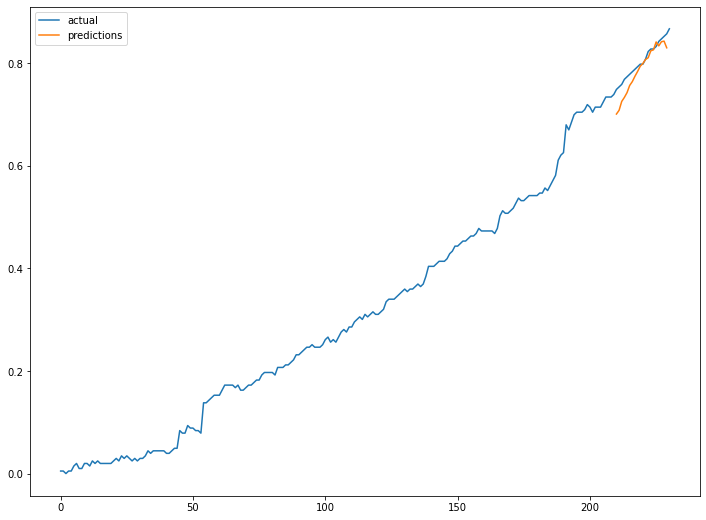

In [17]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 10.204399653843451 actual 0.8006535947712417 prediction 0.7189517
num 1 10.011257663849863 actual 0.8104575163398693 prediction 0.7293205
num 2 7.6071464871785714 actual 0.8137254901960784 prediction 0.7518242
num 3 6.68190059661865 actual 0.8169934640522876 prediction 0.7624028
num 4 5.308619022369383 actual 0.8169934640522876 prediction 0.7736224
num 5 3.213703347392288 actual 0.8202614379084967 prediction 0.79390067
num 6 2.7294538709014713 actual 0.826797385620915 prediction 0.80423033
num 7 2.7796541806310313 actual 0.8366013071895424 prediction 0.8133467
num 8 2.321829851069492 actual 0.8464052287581698 prediction 0.82675314
num 9 1.2591518204787517 actual 0.8529411764705881 prediction 0.84220135
num 10 1.6227205896558679 actual 0.8594771241830064 prediction 0.8455302
num 11 0.83764683116564 actual 0.8627450980392155 prediction 0.85551834
num 12 1.2610415692599097 actual 0.8660130718954246 prediction 0.8550923
num 13 0.10694008953168657 actual 0.8660130718954246 prediction 

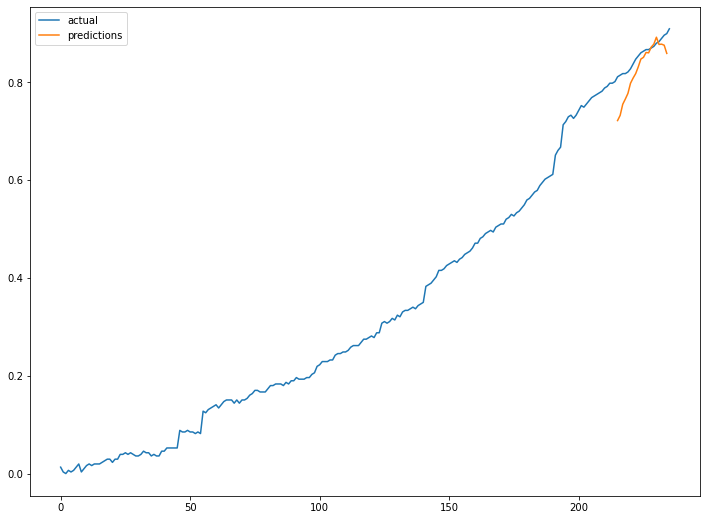

In [18]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 6.399836907020055 actual 0.6190476190476186 prediction 0.65866566
num 1 1.1841118335723 actual 0.6666666666666661 prediction 0.6587726
num 2 7.416530847549339 actual 0.7142857142857135 prediction 0.6613105
num 3 13.424485549330809 actual 0.7619047619047628 prediction 0.65962297
num 4 6.216428279876609 actual 0.7142857142857135 prediction 0.66988266
num 5 1.3034403324128097 actual 0.6666666666666661 prediction 0.67535627
num 6 1.8242627382279348 actual 0.6666666666666661 prediction 0.6788284
num 7 4.724052548408602 actual 0.6666666666666661 prediction 0.69816035
num 8 1.4898180961607836 actual 0.7142857142857135 prediction 0.70364416
num 9 0.3483283519743811 actual 0.7142857142857135 prediction 0.71179765
num 10 1.3631427288056501 actual 0.7142857142857135 prediction 0.72402245
num 11 9.652522206306555 actual 0.6666666666666661 prediction 0.7310168
num 12 5.42171359062206 actual 0.7142857142857135 prediction 0.75301224
num 13 0.8102413266896082 actual 0.7619047619047628 prediction

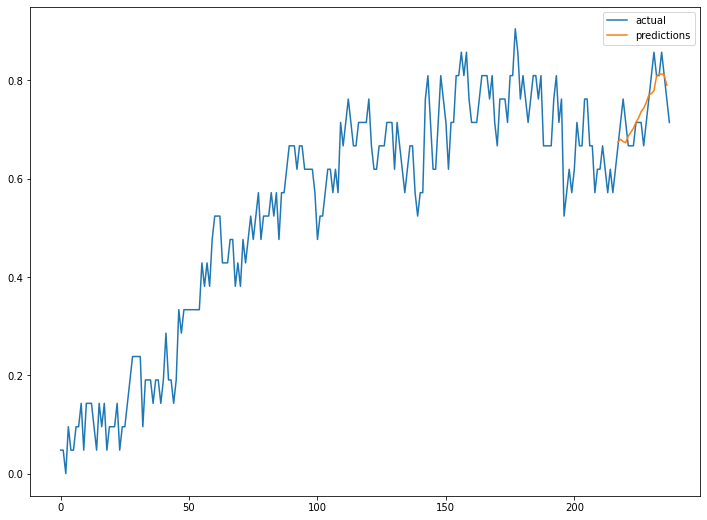

In [19]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

214
(235, 20, 1)
num 0 0.376892366004257 actual 0.6762402088772845 prediction 0.6736915
num 1 1.8398170895648571 actual 0.6892950391644908 prediction 0.6766133
num 2 0.8236156643999392 actual 0.6971279373368144 prediction 0.6913863
num 3 0.7273275834476862 actual 0.702349869451697 prediction 0.6972415
num 4 0.1986924572624222 actual 0.7075718015665795 prediction 0.7061659
num 5 0.007055406152763987 actual 0.7154046997389034 prediction 0.7154552
num 6 0.783665697207157 actual 0.7284595300261096 prediction 0.72275084
num 7 0.6239046477597547 actual 0.7389033942558747 prediction 0.73429334
num 8 1.2163163477535262 actual 0.7493472584856395 prediction 0.7402328
num 9 0.7943342095015219 actual 0.7545691906005221 prediction 0.7485754
num 10 1.3578116486910585 actual 0.7650130548302871 prediction 0.7546256
num 11 0.6967608823257316 actual 0.7676240208877285 prediction 0.7622755
num 12 0.6016883112135308 actual 0.7676240208877285 prediction 0.7722427
num 13 1.1712978350236254 actual 0.77806788

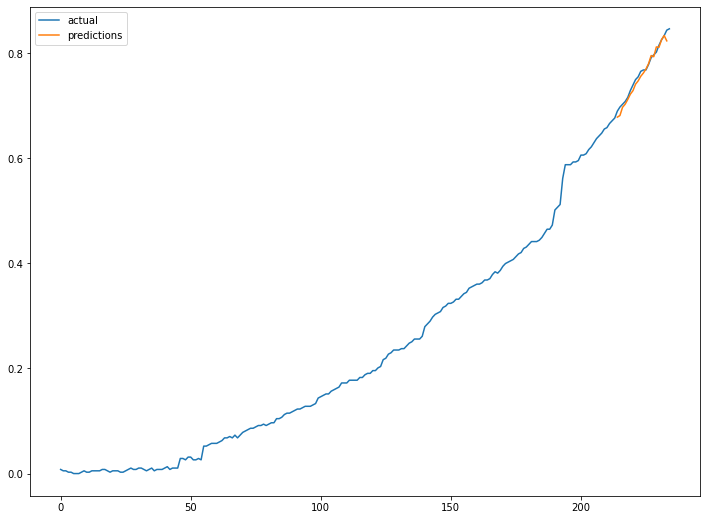

In [20]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

print(plot_len)
print(train_feature2.shape)

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 9.247215170609255 actual 0.7916666666666661 prediction 0.71845955
num 1 6.396943644473358 actual 0.7916666666666661 prediction 0.7410242
num 2 4.485908307527169 actual 0.7916666666666661 prediction 0.7561532
num 3 2.859775225321452 actual 0.75 prediction 0.7714483
num 4 0.5246312994706754 actual 0.7916666666666661 prediction 0.79582
num 5 10.93471844991048 actual 0.75 prediction 0.8320104
num 6 3.31884145736687 actual 0.8333333333333339 prediction 0.86099035
num 7 2.7034211158751713 actual 0.8333333333333339 prediction 0.85586184
num 8 3.0771125446665746 actual 0.9166666666666661 prediction 0.8884598
num 9 3.2675763835078295 actual 0.9583333333333339 prediction 0.92701906
num 10 4.6643651050070645 actual 0.9583333333333339 prediction 0.91363317
num 11 1.3214774753737022 actual 0.9583333333333339 prediction 0.9456692
num 12 1.7783766207488294 actual 0.9583333333333339 prediction 0.94129056
num 13 3.106196030326571 actual 0.9583333333333339 prediction 0.9285656
num 14 4.77050434459

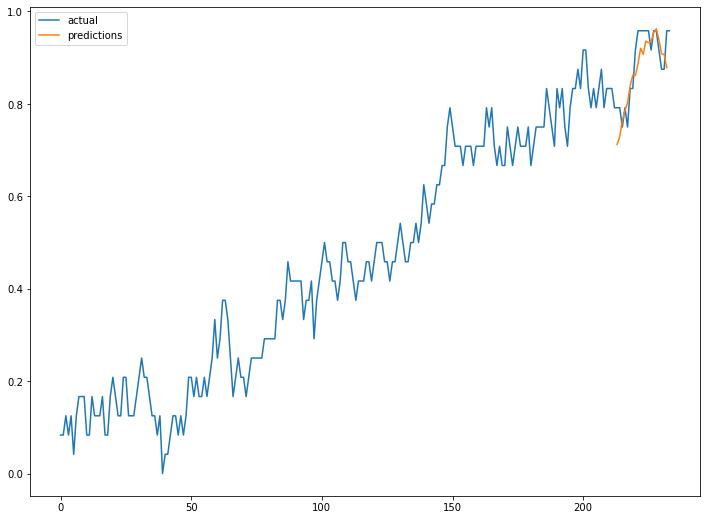

In [21]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 13.526746850264686 actual 0.8482142857142856 prediction 0.7334785
num 1 12.841442227363547 actual 0.8571428571428568 prediction 0.74707335
num 2 9.04619317305714 actual 0.8482142857142856 prediction 0.7714832
num 3 8.047993644993939 actual 0.8526785714285712 prediction 0.78405505
num 4 8.022794035292142 actual 0.8660714285714284 prediction 0.7965883
num 5 6.050348281860352 actual 0.875 prediction 0.82205945
num 6 4.971109186937348 actual 0.8794642857142856 prediction 0.83574516
num 7 5.158271022777421 actual 0.8883928571428568 prediction 0.84256715
num 8 2.706165506382153 actual 0.8839285714285712 prediction 0.860008
num 9 0.9818062710402176 actual 0.8883928571428568 prediction 0.87967056
num 10 0.18926389289621898 actual 0.8839285714285712 prediction 0.8822556
num 11 0.11217117309571024 actual 0.8928571428571428 prediction 0.8938587
num 12 1.333046903704618 actual 0.901785714285714 prediction 0.8897645
num 13 0.8666334481074893 actual 0.90625 prediction 0.89839613
num 14 0.19486

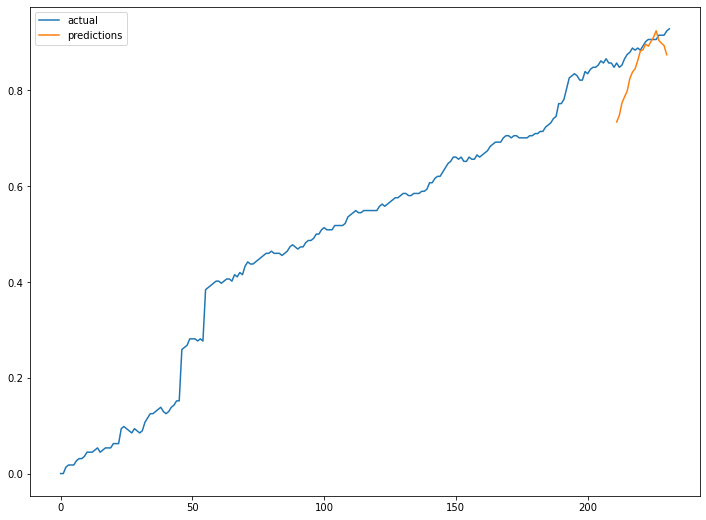

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 17.387092814726127 actual 0.8500000000000014 prediction 0.7022097
num 1 11.013856530189594 actual 0.8000000000000007 prediction 0.71188915
num 2 4.964526494344076 actual 0.75 prediction 0.71276605
num 3 4.4036865234375 actual 0.75 prediction 0.71697235
num 4 4.536088307698568 actual 0.75 prediction 0.71597934
num 5 3.8785219192504883 actual 0.75 prediction 0.7209111
num 6 2.943267141069528 actual 0.7000000000000011 prediction 0.72060287
num 7 3.523331029074375 actual 0.7000000000000011 prediction 0.7246633
num 8 10.861576520479582 actual 0.6500000000000004 prediction 0.72060025
num 9 2.7721336909701284 actual 0.7000000000000011 prediction 0.71940494
num 10 3.260509173075358 actual 0.75 prediction 0.7255462
num 11 3.4192482630411782 actual 0.75 prediction 0.72435564
num 12 2.2525685174123025 actual 0.7000000000000011 prediction 0.715768
num 13 2.885842323303066 actual 0.7000000000000011 prediction 0.7202009
num 14 9.94078665971764 actual 0.8000000000000007 prediction 0.7204737
num

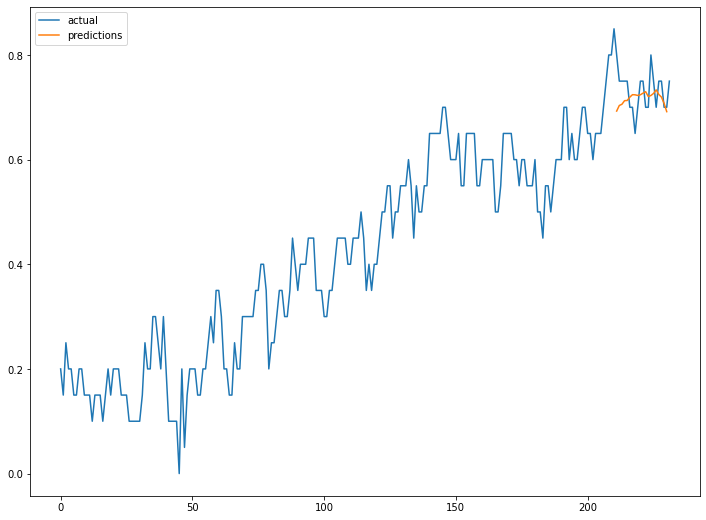

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 17.387092814726127 actual 0.8500000000000014 prediction 0.7022097
num 1 11.013856530189594 actual 0.8000000000000007 prediction 0.71188915
num 2 4.964526494344076 actual 0.75 prediction 0.71276605
num 3 4.4036865234375 actual 0.75 prediction 0.71697235
num 4 4.536088307698568 actual 0.75 prediction 0.71597934
num 5 3.8785219192504883 actual 0.75 prediction 0.7209111
num 6 2.943267141069528 actual 0.7000000000000011 prediction 0.72060287
num 7 3.523331029074375 actual 0.7000000000000011 prediction 0.7246633
num 8 10.861576520479582 actual 0.6500000000000004 prediction 0.72060025
num 9 2.7721336909701284 actual 0.7000000000000011 prediction 0.71940494
num 10 3.260509173075358 actual 0.75 prediction 0.7255462
num 11 3.4192482630411782 actual 0.75 prediction 0.72435564
num 12 2.2525685174123025 actual 0.7000000000000011 prediction 0.715768
num 13 2.885842323303066 actual 0.7000000000000011 prediction 0.7202009
num 14 9.94078665971764 actual 0.8000000000000007 prediction 0.7204737
num

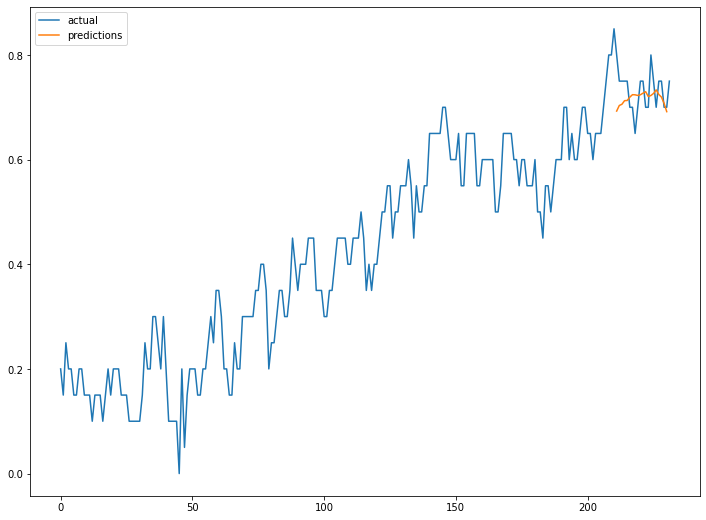

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 13.670576363801858 actual 0.8421052631578938 prediction 0.7269846
num 1 15.476684498064428 actual 0.8684210526315788 prediction 0.73401827
num 2 9.611278399824997 actual 0.8421052631578938 prediction 0.7611682
num 3 11.463969765287437 actual 0.8684210526315788 prediction 0.7688655
num 4 10.510908834861969 actual 0.8684210526315788 prediction 0.7771421
num 5 5.316337943076983 actual 0.8421052631578938 prediction 0.7973361
num 6 2.041892467006465 actual 0.8157894736842097 prediction 0.79913193
num 7 0.2116203308106445 actual 0.8157894736842097 prediction 0.81751585
num 8 1.980523020028959 actual 0.8421052631578938 prediction 0.8254272
num 9 0.36686882376659774 actual 0.8421052631578938 prediction 0.83901584
num 10 2.4834889354127614 actual 0.8684210526315788 prediction 0.8468539
num 11 1.2385606765748194 actual 0.8421052631578938 prediction 0.85253525
num 12 4.000409911660552 actual 0.8947368421052628 prediction 0.8589437
num 13 1.1700691598834632 actual 0.8684210526315788 predicti

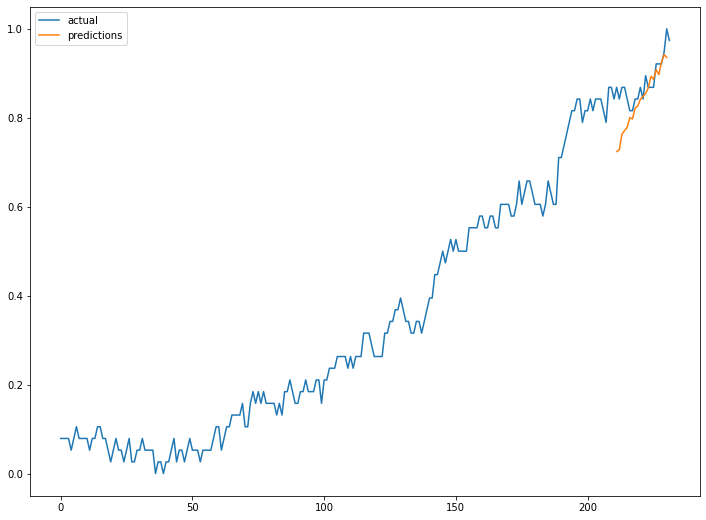

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 9.681382775306798 actual 0.76923076923077 prediction 0.6947586
num 1 4.61171802721538 actual 0.7307692307692317 prediction 0.6970682
num 2 1.5506606352957961 actual 0.7307692307692317 prediction 0.7194375
num 3 0.5747688444038488 actual 0.7307692307692317 prediction 0.726569
num 4 5.978558460871483 actual 0.6923076923076916 prediction 0.7336977
num 5 3.116029500961407 actual 0.76923076923077 prediction 0.7452613
num 6 7.4081914765495 actual 0.8076923076923084 prediction 0.7478569
num 7 5.357645239148901 actual 0.8076923076923084 prediction 0.764419
num 8 9.113624962893457 actual 0.8461538461538467 prediction 0.76903856
num 9 3.934846605573463 actual 0.8076923076923084 prediction 0.77591085
num 10 1.9369435310362684 actual 0.76923076923077 prediction 0.78413033
num 11 2.378970384597669 actual 0.76923076923077 prediction 0.78753054
num 12 3.3564954996107907 actual 0.76923076923077 prediction 0.79504997
num 13 1.1671293349492262 actual 0.8076923076923084 prediction 0.8171191
num 14 

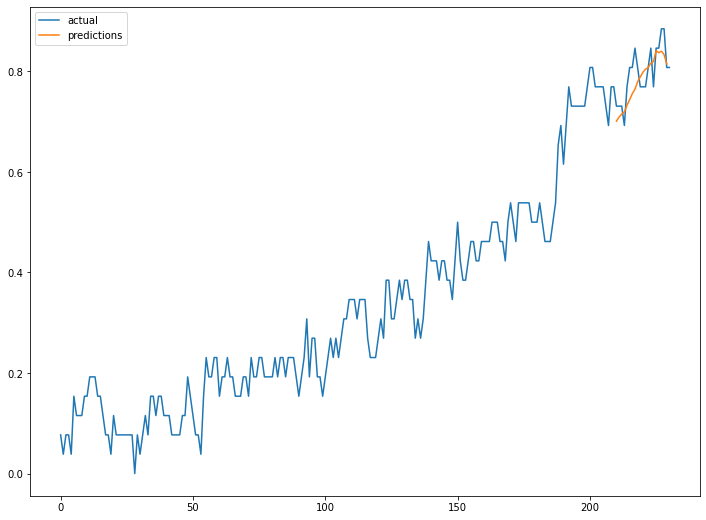

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()